In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/Fraud_Data.csv')
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [ ]:
df.shape

(151112, 12)

In [ ]:
df['class'].value_counts()

,count
class,
0,136961
1,14151


In [ ]:
print(df.dtypes)

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object


In [ ]:
# Convert datetime columns
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

# Create new feature: time difference in seconds
df['time_diff'] = (df['purchase_time'] - df['signup_time']).dt.total_seconds()

df.dropna(inplace=True)

In [ ]:
df['signup_month'] = df['signup_time'].dt.month
df['signup_dayofweek'] = df['signup_time'].dt.dayofweek  # Monday=0, Sunday=6
df['signup_hour'] = df['signup_time'].dt.hour

# Extract components from 'purchase_time'
df['purchase_month'] = df['purchase_time'].dt.month
df['purchase_dayofweek'] = df['purchase_time'].dt.dayofweek
df['purchase_hour'] = df['purchase_time'].dt.hour

In [ ]:
#Encoding categorical features as TabNet prefers numbers
from sklearn.preprocessing import LabelEncoder

categorical_cols = ["device_id", "source", "browser", "sex"]
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [ ]:
# Scaling numerical features
from sklearn.preprocessing import StandardScaler
num_cols = ["purchase_value", "age", "ip_address", "time_diff",
            "signup_month", "signup_dayofweek", "signup_hour",
            "purchase_month", "purchase_dayofweek", "purchase_hour"]
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [ ]:
print(df.dtypes)

user_id                        int64
signup_time           datetime64[ns]
purchase_time         datetime64[ns]
purchase_value               float64
device_id                      int64
source                         int64
browser                        int64
sex                            int64
age                          float64
ip_address                   float64
class                          int64
time_diff                    float64
signup_month                 float64
signup_dayofweek             float64
signup_hour                  float64
purchase_month               float64
purchase_dayofweek           float64
purchase_hour                float64
dtype: object


In [ ]:
# Drop columns not useful for modeling
df_model = df.drop(['user_id', 'signup_time', 'purchase_time'], axis=1)

print(df_model.dtypes)

purchase_value        float64
device_id               int64
source                  int64
browser                 int64
sex                     int64
age                   float64
ip_address            float64
class                   int64
time_diff             float64
signup_month          float64
signup_dayofweek      float64
signup_hour           float64
purchase_month        float64
purchase_dayofweek    float64
purchase_hour         float64
dtype: object


In [ ]:
from sklearn.model_selection import train_test_split

X = df_model.drop("class", axis=1)
y = df_model["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# Debug types
print("X_train types:", set([type(x) for x in X_train.values.ravel()]))
print("y_train types:", set([type(x) for x in y_train.values.ravel()]))
print("Final dtypes:")
print(X_train.dtypes)

X_train types: {<class 'numpy.float64'>}
y_train types: {<class 'numpy.int64'>}
Final dtypes:
purchase_value        float64
device_id               int64
source                  int64
browser                 int64
sex                     int64
age                   float64
ip_address            float64
time_diff             float64
signup_month          float64
signup_dayofweek      float64
signup_hour           float64
purchase_month        float64
purchase_dayofweek    float64
purchase_hour         float64
dtype: object


Training and classifying with TabNet model

In [ ]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
!pip show pytorch-tabnet

Name: pytorch-tabnet
Version: 4.1.0
Summary: PyTorch implementation of TabNet
Home-page: https://github.com/dreamquark-ai/tabnet
Author: 
Author-email: 
License: 
Location: /usr/local/lib/python3.11/dist-packages
Requires: numpy, scikit_learn, scipy, torch, tqdm
Required-by: 


In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
import numpy as np

clf = TabNetClassifier(seed=42)

clf.fit(
    X_train.values, y_train.values,
    eval_set=[(X_test.values, y_test.values)],
    eval_name=["val"],
    eval_metric=["accuracy"],
    max_epochs=50,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.25756 | val_accuracy: 0.93952 |  0:00:07s
epoch 1  | loss: 0.20213 | val_accuracy: 0.95384 |  0:00:15s
epoch 2  | loss: 0.18898 | val_accuracy: 0.95328 |  0:00:23s
epoch 3  | loss: 0.18646 | val_accuracy: 0.9551  |  0:00:30s
epoch 4  | loss: 0.18344 | val_accuracy: 0.94901 |  0:00:39s
epoch 5  | loss: 0.1822  | val_accuracy: 0.95527 |  0:00:46s
epoch 6  | loss: 0.18122 | val_accuracy: 0.90636 |  0:00:54s
epoch 7  | loss: 0.18068 | val_accuracy: 0.90636 |  0:01:01s
epoch 8  | loss: 0.18277 | val_accuracy: 0.95537 |  0:01:10s
epoch 9  | loss: 0.17941 | val_accuracy: 0.90636 |  0:01:18s
epoch 10 | loss: 0.17863 | val_accuracy: 0.9553  |  0:01:25s
epoch 11 | loss: 0.20223 | val_accuracy: 0.90636 |  0:01:34s
epoch 12 | loss: 0.1968  | val_accuracy: 0.95437 |  0:01:41s
epoch 13 | loss: 0.18677 | val_accuracy: 0.9551  |  0:01:49s
epoch 14 | loss: 0.18148 | val_accuracy: 0.95265 |  0:01:56s
epoch 15 | loss: 0.18087 | val_accuracy: 0.9553  |  0:02:05s
epoch 16 | loss: 0.17994

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(X_test.values)

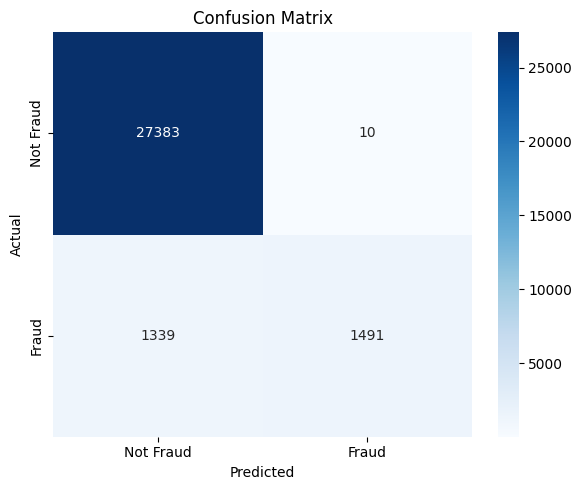

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

labels = ['Not Fraud', 'Fraud']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

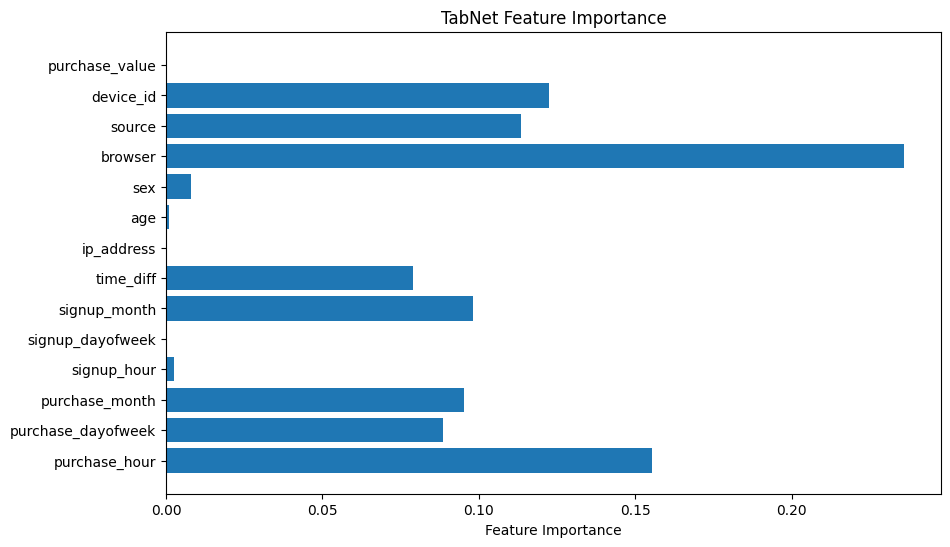

In [ ]:
# Feature Importance
import matplotlib.pyplot as plt

feature_names = X_train.columns.tolist()
importances = clf.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("TabNet Feature Importance")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, f1_score

print("TabNet Classification Report:")
print(classification_report(y_test, y_pred, target_names=labels))

# Predict probabilities for ROC-AUC
y_proba = clf.predict_proba(X_test.values)[:, 1]

# F1-score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

TabNet Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.95      1.00      0.98     27393
       Fraud       0.99      0.53      0.69      2830

    accuracy                           0.96     30223
   macro avg       0.97      0.76      0.83     30223
weighted avg       0.96      0.96      0.95     30223

F1 Score: 0.6885
ROC-AUC Score: 0.7632


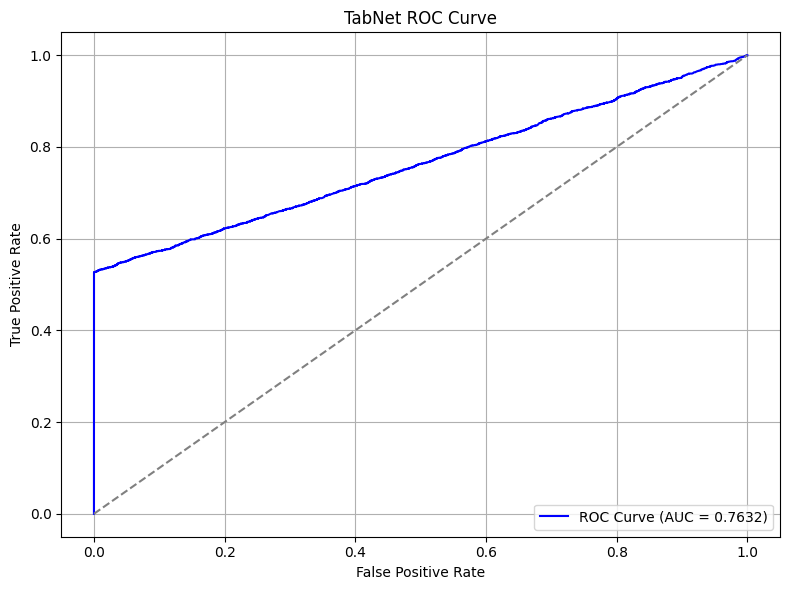

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('TabNet ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

SMOTEENN - It helps balancing the classes by generating synthetic samples of the minority class.

In [ ]:
from imblearn.combine import SMOTEENN
from collections import Counter

smote_enn = SMOTEENN(random_state=42)
X_train_enn, y_train_enn = smote_enn.fit_resample(X_train, y_train)

print("Original class distribution:", Counter(y_train))
print("Resampled class distribution with SMOTEENN:", Counter(X_train_enn))

clf_smoteenn = TabNetClassifier(seed=42)

clf_smoteenn.fit(
    X_train_enn.values, y_train_enn.values,
    eval_set=[(X_test.values, y_test.values)],
    eval_name=["val"],
    eval_metric=["accuracy"],
    max_epochs=50,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128
)

y_pred_smoteenn = clf_smoteenn.predict(X_test.values)

Original class distribution: Counter({0: 109568, 1: 11321})
Resampled class distribution with SMOTEENN: Counter({'purchase_value': 1, 'device_id': 1, 'source': 1, 'browser': 1, 'sex': 1, 'age': 1, 'ip_address': 1, 'time_diff': 1, 'signup_month': 1, 'signup_dayofweek': 1, 'signup_hour': 1, 'purchase_month': 1, 'purchase_dayofweek': 1, 'purchase_hour': 1})


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.42564 | val_accuracy: 0.79502 |  0:00:08s
epoch 1  | loss: 0.36206 | val_accuracy: 0.81187 |  0:00:17s
epoch 2  | loss: 0.35268 | val_accuracy: 0.76931 |  0:00:26s
epoch 3  | loss: 0.34301 | val_accuracy: 0.76647 |  0:00:35s
epoch 4  | loss: 0.33337 | val_accuracy: 0.78139 |  0:00:45s
epoch 5  | loss: 0.3243  | val_accuracy: 0.80604 |  0:00:54s
epoch 6  | loss: 0.31843 | val_accuracy: 0.84244 |  0:01:03s
epoch 7  | loss: 0.33176 | val_accuracy: 0.80386 |  0:01:13s
epoch 8  | loss: 0.31071 | val_accuracy: 0.82546 |  0:01:22s
epoch 9  | loss: 0.32373 | val_accuracy: 0.82996 |  0:01:30s
epoch 10 | loss: 0.32538 | val_accuracy: 0.71803 |  0:01:40s
epoch 11 | loss: 0.30153 | val_accuracy: 0.63859 |  0:01:48s
epoch 12 | loss: 0.29104 | val_accuracy: 0.79042 |  0:01:57s
epoch 13 | loss: 0.27468 | val_accuracy: 0.65903 |  0:02:07s
epoch 14 | loss: 0.26391 | val_accuracy: 0.71654 |  0:02:15s
epoch 15 | loss: 0.24983 | val_accuracy: 0.7762  |  0:02:25s
epoch 16 | loss: 0.24688

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91     27393
           1       0.32      0.60      0.41      2830

    accuracy                           0.84     30223
   macro avg       0.64      0.73      0.66     30223
weighted avg       0.89      0.84      0.86     30223

F1 Score: 0.4143


In [ ]:
# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_smoteenn))

# F1 Score for Fraud class
f1_smoteenn = f1_score(y_test, y_pred_smoteenn)
print("F1 Score:", round(f1_smoteenn, 4))

# ROC AUC
y_proba_smoteenn = clf_smoteenn.predict_proba(X_test.values)[:, 1]
roc_smoteenn = roc_auc_score(y_test, y_proba_smoteenn)
print("ROC AUC Score:", round(roc_smoteenn, 4))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91     27393
           1       0.32      0.60      0.41      2830

    accuracy                           0.84     30223
   macro avg       0.64      0.73      0.66     30223
weighted avg       0.89      0.84      0.86     30223

F1 Score: 0.4143
ROC AUC Score: 0.7623


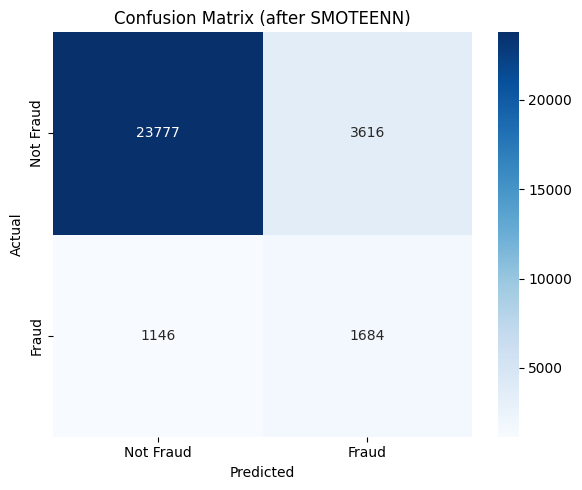

In [ ]:
# Confusion Matrix
cm_smoteenn = confusion_matrix(y_test, y_pred_smoteenn)
labels = ['Not Fraud', 'Fraud']
plt.figure(figsize=(6, 5))
sns.heatmap(cm_smoteenn, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (after SMOTEENN)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

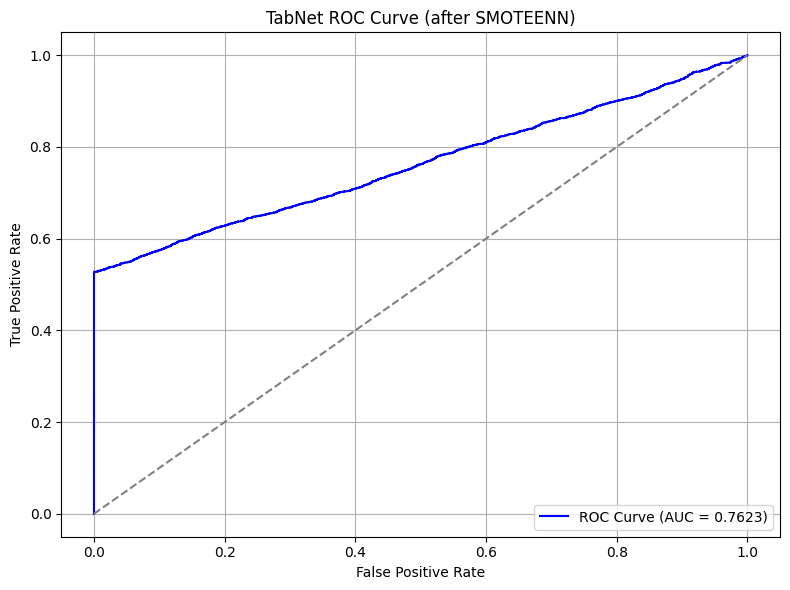

In [ ]:
# ROC Curve
fpr_smoteenn, tpr_smoteenn, thresholds_smoteenn = roc_curve(y_test, y_proba_smoteenn)
plt.figure(figsize=(8, 6))
plt.plot(fpr_smoteenn, tpr_smoteenn, color='blue', label=f'ROC Curve (AUC = {roc_smoteenn:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('TabNet ROC Curve (after SMOTEENN)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()